In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from data_preprocessing import load_data, get_dataloaders, process_df_eps_to_beta
from models import NeuralNet, HybridNeuralNet
from training import train_model, evaluate_model, save_model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cuda'
# Uncomment the following line to force GPU usage if available:
# device = torch.device('cuda')
if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA not available. Using CPU.")

CUDA is available! Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
os.cpu_count()

28

Training NN Model:
Epoch 100/20000, Loss: 0.1430, Test Loss: 0.1201
Epoch 200/20000, Loss: 0.1118, Test Loss: 0.0959
Epoch 300/20000, Loss: 0.1037, Test Loss: 0.0887
Epoch 400/20000, Loss: 0.0999, Test Loss: 0.0835
Epoch 500/20000, Loss: 0.0956, Test Loss: 0.0812
Epoch 600/20000, Loss: 0.0927, Test Loss: 0.0762
Epoch 700/20000, Loss: 0.0874, Test Loss: 0.0749
Epoch 800/20000, Loss: 0.0822, Test Loss: 0.0761
Epoch 900/20000, Loss: 0.0775, Test Loss: 0.0685
Epoch 1000/20000, Loss: 0.0728, Test Loss: 0.0669
Epoch 1100/20000, Loss: 0.0693, Test Loss: 0.0655
Epoch 1200/20000, Loss: 0.0670, Test Loss: 0.0628
Epoch 1300/20000, Loss: 0.0634, Test Loss: 0.0603
Epoch 1400/20000, Loss: 0.0589, Test Loss: 0.0556
Epoch 1500/20000, Loss: 0.0554, Test Loss: 0.0513
Epoch 1600/20000, Loss: 0.0534, Test Loss: 0.0515
Epoch 1700/20000, Loss: 0.0512, Test Loss: 0.0473
Epoch 1800/20000, Loss: 0.0497, Test Loss: 0.0455
Epoch 1900/20000, Loss: 0.0485, Test Loss: 0.0449
Epoch 2000/20000, Loss: 0.0478, Test Los

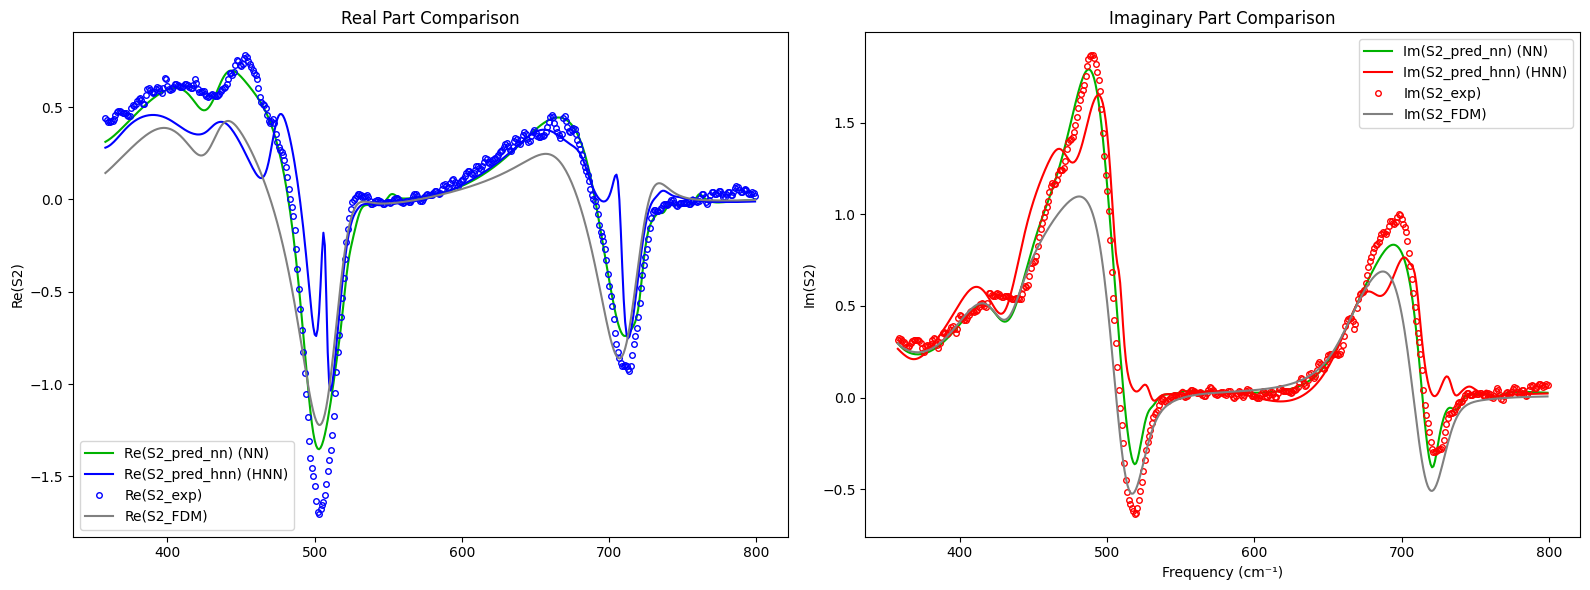

In [3]:

def predict(model, X, device):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        predictions = model(X)
    return predictions.cpu().numpy()

# ---------------------------
# Main Script: Training NN and HNN
# ---------------------------
device = 'cpu'
FILE_PATH = r'C:\nano_optics_ml_data\processed\article_main_data.csv'
NUMBER_OF_EPOCHS = 20000 #150000
BATCH_SIZE_NN = 8 #512
BATCH_SIZE_HNN = 8 #512
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

print("Training NN Model:")
X_train_nn, X_test_nn, y_train_nn, y_test_nn, nn_scaler_x, nn_scaler_y = load_data(FILE_PATH, remove_LSAT=False)
train_loader_nn, test_loader_nn = get_dataloaders(
    X_train_nn, y_train_nn, X_test_nn, y_test_nn, BATCH_SIZE_NN
)
nn_model = NeuralNet(input_size=X_train_nn.shape[1], hidden_size=8).to(device)
criterion = nn.MSELoss()
optimizer_nn = optim.Adam(nn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history_nn = train_model(
    nn_model, 
    train_loader_nn, 
    test_loader_nn, 
    optimizer_nn, 
    criterion, 
    NUMBER_OF_EPOCHS, 
    device,
)
evaluate_model(nn_model, test_loader_nn, criterion, device)
y_pred_nn_scaled = predict(nn_model, X_test_nn, device)
y_pred_nn = nn_scaler_y.inverse_transform(y_pred_nn_scaled)


print("\nTraining HNN Model:")
X_train_hnn, X_test_hnn, y_train_hnn, y_test_hnn, hnn_scaler_x, hnn_scaler_y = load_data(FILE_PATH, ['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag'])
train_loader_hnn, test_loader_hnn = get_dataloaders(X_train_hnn, y_train_hnn, X_test_hnn, y_test_hnn, BATCH_SIZE_HNN)
hnn_model = HybridNeuralNet(input_size=X_train_hnn.shape[1], hidden_size=8).to(device)
optimizer_hnn = optim.Adam(hnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history_hnn = train_model(
    hnn_model, 
    train_loader_hnn, 
    test_loader_hnn, 
    optimizer_hnn, 
    criterion, 
    NUMBER_OF_EPOCHS, 
    device,
)
evaluate_model(hnn_model, test_loader_hnn, criterion, device)
y_pred_hnn_scaled = predict(hnn_model, X_test_hnn, device)
y_pred_hnn = hnn_scaler_y.inverse_transform(y_pred_hnn_scaled)


# ---------------------------
# LSAT Test Predictions and Plotting
# ---------------------------
df = pd.read_csv(FILE_PATH)
df = process_df_eps_to_beta(df)

# Select LSAT test set
test_df = df.query("material == 'LSAT'")[['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag', 'f', 'Sn_exp_real', 'Sn_exp_imag']].copy()

# NN predictions on LSAT (using beta1 and beta2)
X_test_ls_nn = nn_scaler_x.transform(test_df[['beta1', 'beta2']].values.astype(np.float32))
X_test_ls_nn_tensor = torch.from_numpy(X_test_ls_nn).float()
nn_ls_pred_scaled = nn_model(X_test_ls_nn_tensor.to(device)).cpu().detach().numpy()
nn_ls_pred = nn_scaler_y.inverse_transform(nn_ls_pred_scaled)
nn_output_df = pd.DataFrame(nn_ls_pred, columns=['S2_pred_nn_real', 'S2_pred_nn_imag'])

# HNN predictions on LSAT (using beta1, beta2, Sn_fdm_real, Sn_fdm_imag)
X_test_ls_hnn = hnn_scaler_x.transform(test_df[['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag']].values.astype(np.float32))
X_test_ls_hnn_tensor = torch.from_numpy(X_test_ls_hnn).float()
hnn_ls_pred_scaled = hnn_model(X_test_ls_hnn_tensor.to(device)).cpu().detach().numpy()
hnn_ls_pred = hnn_scaler_y.inverse_transform(hnn_ls_pred_scaled)
hnn_output_df = pd.DataFrame(hnn_ls_pred, columns=['S2_pred_hnn_real', 'S2_pred_hnn_imag'])

# Combine predictions with the test data for plotting
output_df = pd.concat([test_df.reset_index(drop=True), nn_output_df, hnn_output_df], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

axes[0].plot(output_df['f'], output_df['S2_pred_nn_real'], 
             label='Re(S2_pred_nn) (NN)', linestyle='-', markersize=4, color='#00B200')
axes[0].plot(output_df['f'], output_df['S2_pred_hnn_real'], 
             label='Re(S2_pred_hnn) (HNN)', linestyle='-', markersize=4, color='blue')
axes[0].plot(output_df['f'], output_df['Sn_exp_real'], 
             label='Re(S2_exp)', marker='o', linestyle='', markersize=4,
             markerfacecolor='none', markeredgecolor='blue')
axes[0].plot(output_df['f'], output_df['Sn_fdm_real'], 
             label='Re(S2_FDM)', linestyle='-', markersize=4, color='gray')
axes[0].set_ylabel('Re(S2)')
axes[0].set_title('Real Part Comparison')
axes[0].legend()

axes[1].plot(output_df['f'], output_df['S2_pred_nn_imag'], 
             label='Im(S2_pred_nn) (NN)', linestyle='-', markersize=4, color='#00B200')
axes[1].plot(output_df['f'], output_df['S2_pred_hnn_imag'], 
             label='Im(S2_pred_hnn) (HNN)', linestyle='-', markersize=4, color='red')
axes[1].plot(output_df['f'], output_df['Sn_exp_imag'], 
             label='Im(S2_exp)', marker='o', linestyle='', markersize=4,
             markerfacecolor='none', markeredgecolor='red')
axes[1].plot(output_df['f'], output_df['Sn_fdm_imag'], 
             label='Im(S2_FDM)', linestyle='-', color='gray')
axes[1].set_ylabel('Im(S2)')
axes[1].set_title('Imaginary Part Comparison')
axes[1].legend()
axes[1].set_xlabel('Frequency (cm⁻¹)')

plt.tight_layout()
plt.show()


In [2]:
save_model(nn_model, 'C:/nano_optics_ml_data/saved_models/nn_model_2.pth')
save_model(hnn_model, 'C:/nano_optics_ml_data/saved_models/hnn_model_2.pth')

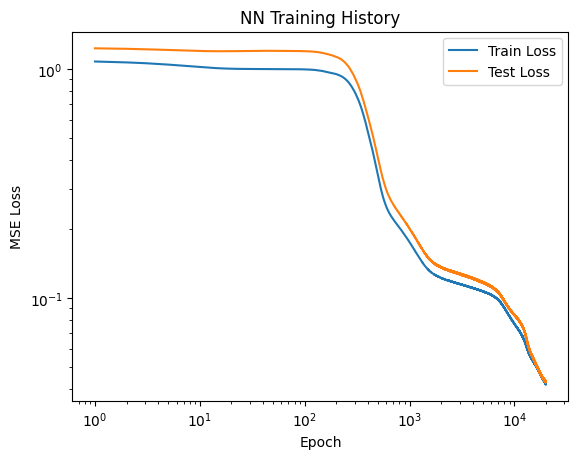

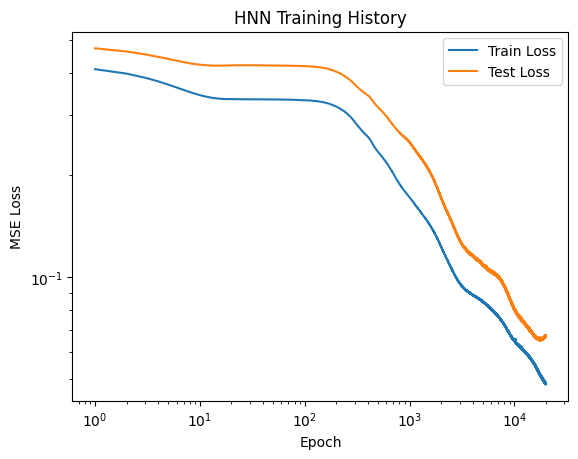

In [11]:
from evaluation.plot_results import plot_training_history

plot_training_history(history_nn, title_prefix='NN')
plot_training_history(history_hnn, title_prefix='HNN')

In [4]:

def finitedipole_2(w,z,eps,a,L,g):
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    W_0 = z + 1.31*a
    W_1 = z + a/2
    for j in range(len(w)):
        for i in range(len(z)):
            f_0 = (g-(a+z[i]+W_0[i])/(2*L))*np.log(4*L/(a+2*z[i]+2*W_0[i]))/np.log(4*L/a)
            f_1 = (g-(a+z[i]+W_1[i])/(2*L))*np.log(4*L/(a+2*z[i]+2*W_1[i]))/np.log(4*L/a)
            alpha_eff[j,i] = beta[j]*f_0/(1-beta[j]*f_1)
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff

def demodulate(alpha_eff,t,n):
    fourier=np.cos(n*t)
    fourier=np.repeat(fourier[:,np.newaxis],len(alpha_eff[1,:]),1)
    Sn=np.trapz(alpha_eff*fourier,axis=0)
    return Sn

def Sn_2(w,eps,z,a,L,g,t,n):
    s_samp=demodulate(finitedipole_2(w,z,eps,a,L,g),t,n)
    eps_ref = np.ones(1)*(-10000+10000*1j)
    s_ref=demodulate(finitedipole_2([1],z,eps_ref,a,L,g),t,n)
    sn=s_samp/s_ref
    return sn

def farfieldfactor(f, eps):
    import math
    f = np.atleast_1d(f)  # Ensure f is an array
    n0 = np.ones(f.shape)
    n1 = np.sqrt((0.5*np.sqrt(eps*np.conj(eps)) + np.real(eps)/2)) + \
         np.sqrt((0.5*np.sqrt(eps*np.conj(eps)) - np.real(eps)/2))*1j
    theta = math.pi/3
    cos_theta_t = np.sqrt(1 - (n0*np.sin(theta)/n1)**2)
    r = (-n0*cos_theta_t + n1*np.cos(theta)) / (n0*cos_theta_t + n1*np.cos(theta))
    FFF = (1 + r)**2
    # If f was a scalar, return a scalar
    if FFF.size == 1:
        return FFF[0]
    return FFF


In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

############################################
# 1) Generate a dense grid of epsilon values
############################################
def generate_symlog_like_epsilon(num_points=200, linthresh=1):
    """
    Generate a piecewise 'symlog' style array on [-1e3, 1e3].
    'linthresh' sets the half-range of the linear region around 0.
    """
    # 1) Log-spaced negative portion (from -1e3 to -linthresh)
    neg_part = -np.logspace(np.log10(linthresh), np.log10(1e3), num_points//4)[::-1]
    
    # 2) Linear portion around zero ([-linthresh, linthresh])
    lin_part = np.linspace(-linthresh, linthresh, num_points//2)
    
    # 3) Log-spaced positive portion ([linthresh, 1e3])
    pos_part = np.logspace(np.log10(linthresh), np.log10(1e3), num_points//4)

    eps1_symlog = np.concatenate([neg_part, lin_part, pos_part])
    return eps1_symlog

def generate_epsilon_grid(eps1_min, eps1_max, eps2_min, eps2_max, num_points=200):
    """
    Create a 2D grid of complex eps values:
      - Real(eps) in [eps1_min, eps1_max]
      - Imag(eps) in [eps2_min, eps2_max]
    Returns (eps_grid, Eps1, Eps2)
    """
    # eps1 = np.linspace(eps1_min, eps1_max, num_points)
    # eps2 = np.linspace(eps2_min, eps2_max, num_points)
    eps1 = generate_symlog_like_epsilon(num_points, linthresh=1)
    eps2 = generate_symlog_like_epsilon(num_points, linthresh=2)

    Eps1, Eps2 = np.meshgrid(eps1, eps2)
    eps_grid = Eps1 + 1j * Eps2
    return eps_grid, Eps1, Eps2

def compute_beta(eps):
    """Compute beta = (eps - 1)/(eps + 1)."""
    return (eps - 1) / (eps + 1)

import numpy as np
import math

def get_fdm_prediction(eps_array, freq=500, a=50, L=500, A=68, h0=0, g=0.7*np.exp(0.07*1j), n=2, n_points=30):
    """
    Compute the baseline FDM prediction for each element in eps_array
    at a single frequency (freq).
    
    Parameters
    ----------
    eps_array : array-like of complex
        The array of complex permittivities for which we want the baseline FDM.
    freq : float, optional
        The frequency at which we compute the FDM (in cm^-1).
    a, L, A, h0, g, n, n_points : various, optional
        Physical parameters used in your FDM code. The defaults are based on
        your example scripts.
    """
    # Create the tapping motion array
    t = np.linspace(0, math.pi, n_points)
    z = A - A*np.cos(t) + h0
    
    # Helper function to compute the FDM for a single eps
    def fdm_for_one_eps(eps):
        # farfieldfactor(freq, eps) expects freq to be an array or at least 1D
        # but we can pass a scalar if you updated farfieldfactor to handle that
        ff = farfieldfactor(freq, eps)
        # Sn_2 also typically expects arrays, so we wrap freq and eps in 1-element arrays
        sn_val = Sn_2(np.array([freq]), np.array([eps]), z, a, L, g, t, n)  # returns array of length 1
        return 0.25 * ff * sn_val[0]
    
    # Loop over all eps values
    eps_array = np.asarray(eps_array, dtype=complex)
    fdm_out = np.empty_like(eps_array, dtype=complex)
    
    for i, eps_val in enumerate(eps_array):
        fdm_out[i] = fdm_for_one_eps(eps_val)
    
    return fdm_out


############################################
# 2) Predict S2 on a grid for NN and HNN
############################################
def predict_nn_on_grid(nn_model, nn_scaler, eps_grid, device='cpu'):
    """
    For each point in eps_grid, compute [Re(S2), Im(S2)] using the NN model
    with features [Re(beta), Im(beta)].
    """
    # Flatten the grid for batch processing
    eps_flat = eps_grid.ravel()
    beta_flat = compute_beta(eps_flat)
    # Build features: [beta1, beta2]
    X_nn = np.column_stack([beta_flat.real, beta_flat.imag]).astype(np.float32)
    # Scale the features
    X_nn_scaled = nn_scaler.transform(X_nn)
    # Predict with NN
    tensor_nn = torch.from_numpy(X_nn_scaled).float().to(device)
    with torch.no_grad():
        pred = nn_model(tensor_nn).cpu().numpy()  # shape: (N, 2)
    # Reshape back to grid
    pred = pred.reshape(eps_grid.shape[0], eps_grid.shape[1], 2)
    return pred

def predict_hnn_on_grid(hnn_model, hnn_scaler, eps_grid, device='cpu'):
    """
    For each point in eps_grid, compute [Re(S2), Im(S2)] using the HNN model
    with features [Re(beta), Im(beta), Re(FDM), Im(FDM)].
    We'll assume you have a function get_fdm_prediction(eps_flat) that returns
    the baseline FDM predictions for each eps.
    """
    # Flatten
    eps_flat = eps_grid.ravel()
    beta_flat = compute_beta(eps_flat)

    # 2a) Compute baseline FDM predictions for each eps in eps_flat
    #     You can adapt your FDM code or define a vectorized approach.
    #     For example:
    fdm_flat = get_fdm_prediction(eps_flat)  # shape (N,) of complex
    # Build features: [beta1, beta2, fdm_real, fdm_imag]
    X_hnn = np.column_stack([
        beta_flat.real,
        beta_flat.imag,
        fdm_flat.real,
        fdm_flat.imag
    ]).astype(np.float32)

    # Scale
    X_hnn_scaled = hnn_scaler.transform(X_hnn)
    tensor_hnn = torch.from_numpy(X_hnn_scaled).float().to(device)
    with torch.no_grad():
        pred = hnn_model(tensor_hnn).cpu().numpy()  # shape: (N, 2)
    pred = pred.reshape(eps_grid.shape[0], eps_grid.shape[1], 2)
    return pred

############################################
# 3) Overlay predictions for training data
############################################
def predict_model_for_data(df, model, scaler, device='cpu', is_hnn=False):
    """
    Compute model predictions for each row in df, returning arrays:
      eps1_data, eps2_data, pred_real, pred_imag
    """
    eps1_data = df['eps1'].values
    eps2_data = df['eps2'].values
    beta_data = compute_beta(eps1_data + 1j*eps2_data)

    if not is_hnn:
        # NN case
        X_data = np.column_stack([beta_data.real, beta_data.imag]).astype(np.float32)
        X_scaled = scaler.transform(X_data)
    else:
        # HNN case
        fdm_real = df['Sn_fdm_real'].values
        fdm_imag = df['Sn_fdm_imag'].values
        X_data = np.column_stack([
            beta_data.real,
            beta_data.imag,
            fdm_real,
            fdm_imag
        ]).astype(np.float32)
        X_scaled = scaler.transform(X_data)

    tensor_data = torch.from_numpy(X_scaled).float().to(device)
    with torch.no_grad():
        pred_data = model(tensor_data).cpu().numpy()  # shape (N, 2)
    pred_real = pred_data[:, 0]
    pred_imag = pred_data[:, 1]
    return eps1_data, eps2_data, pred_real, pred_imag

############################################
# 4) Plot function using pcolormesh
############################################
def plot_model_results(Eps1, Eps2, S2_pred, 
                       eps1_data, eps2_data, pred_real_data, pred_imag_data,
                       title_prefix="NN", vmin=-1.5, vmax=1.5):
    """
    Creates two subplots for Re(S2) and Im(S2), using pcolormesh to fill the plane,
    then overlays training/testing points in scatter form.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)

    norm = mcolors.CenteredNorm(vcenter=0, halfrange=1.5)

    # Real part
    mesh0 = axes[0].pcolormesh(Eps1, Eps2, S2_pred[:, :, 0],
                               cmap='bwr', norm=norm, shading='auto')
    sc0 = axes[0].scatter(eps1_data, eps2_data, 
                          c=pred_real_data, cmap='bwr', norm=norm, s=15, edgecolors='k', linewidths=0.05)
    axes[0].set_xscale('symlog', linthresh=1)
    axes[0].set_yscale('symlog', linthresh=2)
    axes[0].set_xlabel(r'$\epsilon_1$')
    axes[0].set_ylabel(r'$\epsilon_2$')
    axes[0].set_title(f"Re($S_2^{{{title_prefix}}}$)")

    cb0 = fig.colorbar(mesh0, ax=axes[0], shrink=0.8)
    cb0.set_label("Real part")

    # Imag part
    mesh1 = axes[1].pcolormesh(Eps1, Eps2, S2_pred[:, :, 1],
                               cmap='bwr', norm=norm, shading='auto')
    sc1 = axes[1].scatter(eps1_data, eps2_data,
                          c=pred_imag_data, cmap='bwr', norm=norm, s=15, edgecolors='k', linewidths=0.05)
    axes[1].set_xscale('symlog', linthresh=1)
    axes[1].set_yscale('symlog', linthresh=2)
    axes[1].set_xlabel(r'$\epsilon_1$')
    axes[1].set_ylabel(r'$\epsilon_2$')
    axes[1].set_title(f"Im($S_2^{{{title_prefix}}}$)")

    cb1 = fig.colorbar(mesh1, ax=axes[1], shrink=0.8)
    cb1.set_label("Imag part")

    # Ticks for symlog
    axes[0].set_xticks([-1e3, -1e2, -10, -1, 0, 1, 10, 1e2, 1e3])
    axes[0].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'$-10^0$', '0', 
                             r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[0].set_yticks([0, 1, 10, 1e2, 1e3])
    axes[0].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[0].set_ylim(bottom=0)

    axes[1].set_xticks([-1e3, -1e2, -10, -1, 0, 1, 10, 1e2, 1e3])
    axes[1].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'$-10^0$', '0', 
                             r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[1].set_yticks([0, 1, 10, 1e2, 1e3])
    axes[1].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[1].set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()


In [6]:

############################################
# MAIN EXAMPLE
############################################
# 1) Generate grid
eps_grid, Eps1, Eps2 = generate_epsilon_grid(eps1_min=-1e3, eps1_max=1e3,
                                            eps2_min=0,   eps2_max=1e3,
                                            num_points=500)

# 2) Predict on grid (NN)
S2_nn_grid = predict_nn_on_grid(nn_model, nn_scaler, eps_grid, device=device)

# 2b) Predict on grid (HNN)
S2_hnn_grid = predict_hnn_on_grid(hnn_model, hnn_scaler, eps_grid, device=device)

# 3) Get predictions for the actual training/testing data from final_df
#    (We overlay these data points on the colormap.)
df = df.copy()  # Or however you loaded your main DataFrame
eps1_data_nn, eps2_data_nn, nn_pred_real_data, nn_pred_imag_data = \
    predict_model_for_data(df, nn_model, nn_scaler, device=device, is_hnn=False)

eps1_data_hnn, eps2_data_hnn, hnn_pred_real_data, hnn_pred_imag_data = \
    predict_model_for_data(df, hnn_model, hnn_scaler, device=device, is_hnn=True)


NameError: name 'nn_scaler' is not defined

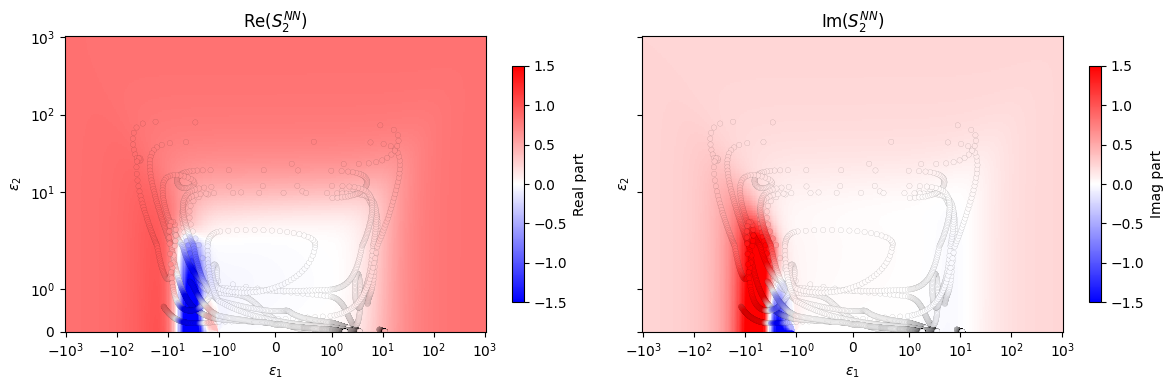

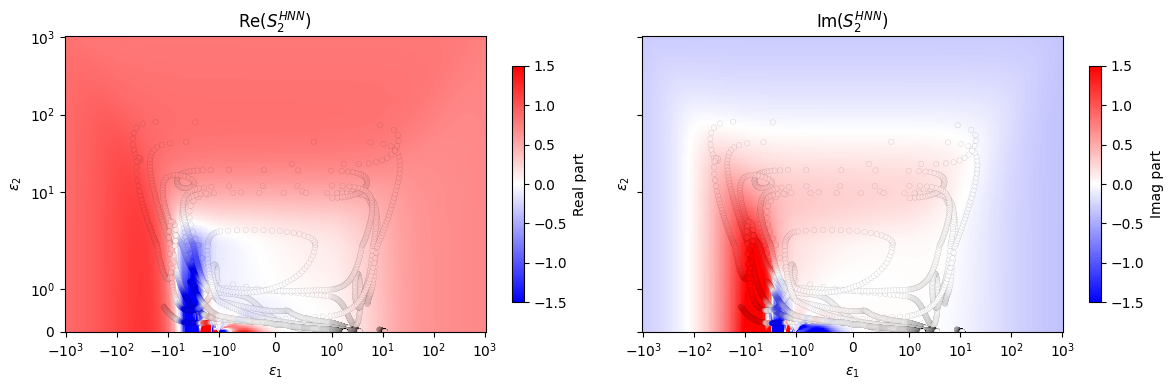

In [ ]:

# 4) Plot NN
plot_model_results(Eps1, Eps2, S2_nn_grid,
                   eps1_data_nn, eps2_data_nn, nn_pred_real_data, nn_pred_imag_data,
                   title_prefix="NN")

# 5) Plot HNN
plot_model_results(Eps1, Eps2, S2_hnn_grid,
                   eps1_data_hnn, eps2_data_hnn, hnn_pred_real_data, hnn_pred_imag_data,
                   title_prefix="HNN")
